# This notebook was used to generate data for experiment 2

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from itertools import product
from collections import defaultdict
import sys
sys.path.append('../fpgp')
import utils
from plotting_tools import names_to_latex

In [16]:
base_dir = '../data'
dirs, thresholds = ('001_fitness/f1', '05_fitness/f2', '15_fitness/f3', '0025_fitness/f4', '0025_fitness/f5', '15_fitness/yachts'), \
                  (0.01, 0.5, 1.5, 0.025, 0.025, 1.5)
#dirs, thresholds = ('05_fitness/f2', ), \
                 # (0.5,)

In [42]:
stats = defaultdict(dict)
for d, t in zip(dirs, thresholds):
    dir_ = os.path.join(base_dir, d)
    logs, names = utils.get_results(dir_)
    for ll, name in zip(logs, names):
        f = utils.get_attributes_from_logs(ll, 'test_set_f')
        times = utils.get_attributes_from_logs(ll, 'time')
        evals = utils.get_attributes_from_logs(ll, 'evals')
        gens = utils.get_attributes_from_logs(ll, 'gen')
        success_rate = np.sum(f <= t) / len(f)
        median_evals = np.median(evals[f <= t])
        stats[name][d] = {
            'success_rate': success_rate,
            'median_gens': np.median(gens[f <= t]),
            'median_evals': np.median(evals[f <= t]),
            'median_time': np.median(times[f <= t]),
            'mean_gens': np.mean(gens[f <= t]),
            'mean_evals': np.mean(evals[f <= t]),
            'mean_time': np.mean(times[f <= t]),
            'mean_evals_fail': np.mean(evals[f > t]) if success_rate < 1 else 0,
            'fitnesses': f
        }

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
for alg, data in stats.items():
    for k, test in data.items():
        n = 1 / test['success_rate']
        test['expected_time'] = (n - 1)*300 + test['mean_time']
        if np.isnan(test['mean_evals_fail']):
            test['mean_evals_fail'] = 0
        test['expected_evals'] = (n - 1) * test['mean_evals_fail'] + test['mean_evals']

In [21]:
with open('stats.p', 'wb') as f:
    pickle.dump(stats, f)
del stats

In [2]:
with open('stats.p', 'rb') as f:
    stats = pickle.load(f)

In [19]:
def normalize(stats_, max_, new_keys=None):
    if new_keys is None:
        new_keys = [s + '_normalized' for s in stats_]
    for s, m, k_ in zip(stats_, max_, new_keys):
        for alg, data in stats.items():
            for k, test in data.items():
                best = -np.inf if m else np.inf
                best_func = max if m else min
                for alg_, data_ in stats.items():
                    best = best_func(best, data_[k][s])
                best
                test[k_] =  test[s] / best if m else best / test[s]

In [20]:
normalize(['expected_time', 'expected_evals'], [False, False])

In [4]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:.2}'.format(height),
                ha='center', va='bottom')

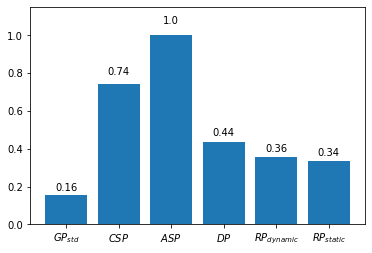

In [15]:
from matplotlib.ticker import StrMethodFormatter
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1e}')) # 2 decimal places
ticks = []
heights = []
errors = []
for k, s in stats.items():
    ticks.append(k)
    heights.append(np.median([ss['expected_evals_normalized'] for _, ss in s.items()]))
    errors.append(np.std([ss['expected_evals_normalized'] for _, ss in s.items()]))
ticks[0], ticks[1] = ticks[1], ticks[0]
heights[0], heights[1] = heights[1], heights[0]
errors[0], errors[1] = errors[1], errors[0]
rects = plt.bar(names_to_latex(ticks), heights)
autolabel(rects)
plt.ylim(0, 1.15)
plt.savefig('score_evals_med.pdf')
plt.show()

In [12]:
methods = ['exact', 'SLcoev', 'DScoev', 'my2', 'static', 'dynamic']
stats_ = ['success_rate']
functions = ['001_fitness/f1', '05_fitness/f2', '15_fitness/f3', '0025_fitness/f4', '0025_fitness/f5', '15_fitness/yachts']
idxs = pd.MultiIndex.from_product([stats_, names_to_latex(methods)])
table = np.zeros((len(methods) * len(stats_), len(functions)))
for (i, method), (j, func), (k, stat) in product(enumerate(methods), enumerate(functions), enumerate(stats_)):
    table[i + k*len(methods)][j] = stats[method][func][stat]
df1 = pd.DataFrame(table, index=idxs, columns=[os.path.basename(f) for f in functions])

In [13]:
methods = ['exact', 'SLcoev', 'DScoev', 'my2', 'static', 'dynamic']
stats_ = ['mean_time']
functions = ['001_fitness/f1', '05_fitness/f2', '15_fitness/f3', '0025_fitness/f4', '0025_fitness/f5', '15_fitness/yachts']
idxs = pd.MultiIndex.from_product([stats_, names_to_latex(methods)])
table = np.zeros((len(methods) * len(stats_), len(functions)))
for (i, method), (j, func), (k, stat) in product(enumerate(methods), enumerate(functions), enumerate(stats_)):
    table[i + k*len(methods)][j] = stats[method][func][stat]
df2 = pd.DataFrame(table, index=idxs, columns=[os.path.basename(f) for f in functions])

In [14]:
methods = ['exact', 'SLcoev', 'DScoev', 'my2', 'static', 'dynamic']
stats_ = ['mean_evals']
functions = ['001_fitness/f1', '05_fitness/f2', '15_fitness/f3', '0025_fitness/f4', '0025_fitness/f5', '15_fitness/yachts']
idxs = pd.MultiIndex.from_product([stats_, names_to_latex(methods)])
table = np.zeros((len(methods) * len(stats_), len(functions)))
for (i, method), (j, func), (k, stat) in product(enumerate(methods), enumerate(functions), enumerate(stats_)):
    table[i + k*len(methods)][j] = stats[method][func][stat]
df3 = pd.DataFrame(table, index=idxs, columns=[os.path.basename(f) for f in functions])

In [15]:
methods = ['exact', 'SLcoev', 'DScoev', 'my2', 'static', 'dynamic']
stats_ = ['expected_time']
functions = ['001_fitness/f1', '05_fitness/f2', '15_fitness/f3', '0025_fitness/f4', '0025_fitness/f5', '15_fitness/yachts']
idxs = pd.MultiIndex.from_product([stats_, names_to_latex(methods)])
table = np.zeros((len(methods) * len(stats_), len(functions)))
for (i, method), (j, func), (k, stat) in product(enumerate(methods), enumerate(functions), enumerate(stats_)):
    table[i + k*len(methods)][j] = stats[method][func][stat]
df4 = pd.DataFrame(table, index=idxs, columns=[os.path.basename(f) for f in functions])

In [16]:
methods = ['exact', 'SLcoev', 'DScoev', 'my2', 'static', 'dynamic']
stats_ = ['expected_evals']
functions = ['001_fitness/f1', '05_fitness/f2', '15_fitness/f3', '0025_fitness/f4', '0025_fitness/f5', '15_fitness/yachts']
idxs = pd.MultiIndex.from_product([stats_, names_to_latex(methods)])
table = np.zeros((len(methods) * len(stats_), len(functions)))
for (i, method), (j, func), (k, stat) in product(enumerate(methods), enumerate(functions), enumerate(stats_)):
    table[i + k*len(methods)][j] = stats[method][func][stat]
df5 = pd.DataFrame(table, index=idxs, columns=[os.path.basename(f) for f in functions])

In [30]:
methods = ['exact', 'SLcoev', 'DScoev', 'my2', 'static', 'dynamic']
stats_ = ['expected_evals_normalized']
functions = ['001_fitness/f1', '05_fitness/f2', '15_fitness/f3', '0025_fitness/f4', '0025_fitness/f5', '15_fitness/yachts']
idxs = pd.MultiIndex.from_product([stats_, names_to_latex(methods)])
table = np.zeros((len(methods) * len(stats_), len(functions)))
for (i, method), (j, func), (k, stat) in product(enumerate(methods), enumerate(functions), enumerate(stats_)):
    table[i + k*len(methods)][j] = stats[method][func][stat]
df6 = pd.DataFrame(table, index=idxs, columns=[os.path.basename(f) for f in functions])

In [31]:
df6

f1        f2        f3  \
expected_evals_normalized $GP_{std}$      0.024697  0.191466  0.275484   
                          $CSP$           0.073040  0.978091  0.691017   
                          $ASP$           0.139640  1.000000  1.000000   
                          $DP$            1.000000  0.281406  0.445402   
                          $RP_{static}$   0.053532  0.394661  0.324146   
                          $RP_{dynamic}$  0.085939  0.117629  0.427291   

                                                f4        f5    yachts  
expected_evals_normalized $GP_{std}$      0.123931  0.063718  0.911869  
                          $CSP$           0.825469  0.795346  0.178502  
                          $ASP$           1.000000  1.000000  1.000000  
                          $DP$            0.392165  0.747088  0.427760  
                          $RP_{static}$   0.351722  0.794358  0.223147  
                          $RP_{dynamic}$  0.451223  0.336282  0.376385

In [17]:
print(df1.to_latex(multirow=True, multicolumn=True, formatters=6*[lambda x: '{:0.0f}%'.format(100*x)]))

\begin{tabular}{llrrrrrr}
\toprule
             &                &   f1 &  f2 &  f3 &  f4 &  f5 & yachts \\
\midrule
\multirow{6}{*}{success\_rate} & \$GP\_\{std\}\$ &  88\% & 57\% & 78\% & 18\% &  4\% &   100\% \\
             & \$CSP\$ &  88\% & 76\% & 78\% & 46\% & 20\% &    17\% \\
             & \$ASP\$ &  94\% & 67\% & 86\% & 52\% & 17\% &    86\% \\
             & \$DP\$ & 100\% & 45\% & 71\% & 33\% & 25\% &    57\% \\
             & \$RP\_\{static\}\$ &  82\% & 45\% & 53\% & 22\% & 19\% &    20\% \\
             & \$RP\_\{dynamic\}\$ &  92\% & 31\% & 78\% & 39\% & 11\% &    39\% \\
\bottomrule
\end{tabular}



In [18]:
print(df2.to_latex(multirow=True, multicolumn=True, formatters=6*[lambda x: '{:0.2f}'.format(x)]))

\begin{tabular}{llrrrrrr}
\toprule
          &                &    f1 &     f2 &    f3 &     f4 &     f5 & yachts \\
\midrule
\multirow{6}{*}{mean\_time} & \$GP\_\{std\}\$ & 22.95 & 112.52 & 68.90 & 198.72 & 191.84 &  43.83 \\
          & \$CSP\$ &  6.68 &  55.04 & 54.68 & 132.01 & 166.90 &  50.66 \\
          & \$ASP\$ & 10.72 &  24.73 & 63.54 & 193.31 & 144.02 &  76.80 \\
          & \$DP\$ &  2.48 &  60.21 & 71.33 & 172.27 & 164.67 &  78.03 \\
          & \$RP\_\{static\}\$ &  5.86 &  52.82 & 43.61 & 146.75 & 134.43 &  44.36 \\
          & \$RP\_\{dynamic\}\$ &  8.01 &  91.43 & 87.43 & 191.97 & 120.23 & 120.01 \\
\bottomrule
\end{tabular}



In [24]:
print(df3.to_latex(multirow=True, multicolumn=True, formatters=6*[lambda x: '${:0.2f} timestenseven$'.format(x / 1e6)]))

\begin{tabular}{llrrrrrr}
\toprule
           &                &                   f1 &                    f2 &                    f3 &                    f4 &                    f5 &               yachts \\
\midrule
\multirow{6}{*}{mean\_evals} & \$GP\_\{std\}\$ & \$5.01 timestenseven\$ & \$23.08 timestenseven\$ & \$12.82 timestenseven\$ & \$33.72 timestenseven\$ & \$42.81 timestenseven\$ & \$8.60 timestenseven\$ \\
           & \$CSP\$ & \$0.82 timestenseven\$ &  \$4.98 timestenseven\$ &  \$4.53 timestenseven\$ & \$10.43 timestenseven\$ & \$15.57 timestenseven\$ & \$1.79 timestenseven\$ \\
           & \$ASP\$ & \$0.88 timestenseven\$ &  \$1.84 timestenseven\$ &  \$3.95 timestenseven\$ & \$12.50 timestenseven\$ &  \$8.46 timestenseven\$ & \$5.06 timestenseven\$ \\
           & \$DP\$ & \$0.26 timestenseven\$ &  \$5.85 timestenseven\$ &  \$5.81 timestenseven\$ & \$15.91 timestenseven\$ & \$21.25 timestenseven\$ & \$4.71 timestenseven\$ \\
           & \$RP\_\{static\}\$ & \$0.72 times

In [20]:
print(df4.to_latex(multirow=True, multicolumn=True, formatters=6*[lambda x: '{:0.2f}'.format(x)]))

\begin{tabular}{llrrrrrr}
\toprule
              &                &    f1 &     f2 &     f3 &      f4 &      f5 &  yachts \\
\midrule
\multirow{6}{*}{expected\_time} & \$GP\_\{std\}\$ & 63.86 & 340.11 & 155.74 & 1565.39 & 7391.84 &   43.83 \\
              & \$CSP\$ & 47.59 & 147.35 & 137.18 &  484.18 & 1366.90 & 1483.99 \\
              & \$ASP\$ & 29.87 & 174.73 & 113.54 &  470.24 & 1644.02 &  124.53 \\
              & \$DP\$ &  2.48 & 428.40 & 191.33 &  791.02 & 1064.67 &  303.03 \\
              & \$RP\_\{static\}\$ & 71.71 & 418.04 & 308.99 & 1183.11 & 1401.10 & 1244.36 \\
              & \$RP\_\{dynamic\}\$ & 34.09 & 747.68 & 174.28 &  665.65 & 2640.23 &  593.70 \\
\bottomrule
\end{tabular}



In [23]:
print(df5.to_latex(multirow=True, multicolumn=True, formatters=6*[lambda x: '${:0.2f} timestenseven$'.format(x / 1e7)]))

\begin{tabular}{llrrrrrr}
\toprule
               &                &                   f1 &                   f2 &                   f3 &                    f4 &                     f5 &               yachts \\
\midrule
\multirow{6}{*}{expected\_evals} & \$GP\_\{std\}\$ & \$1.05 timestenseven\$ & \$5.91 timestenseven\$ & \$2.50 timestenseven\$ & \$23.14 timestenseven\$ & \$154.52 timestenseven\$ & \$0.86 timestenseven\$ \\
               & \$CSP\$ & \$0.36 timestenseven\$ & \$1.16 timestenseven\$ & \$1.00 timestenseven\$ &  \$3.47 timestenseven\$ &  \$12.38 timestenseven\$ & \$4.39 timestenseven\$ \\
               & \$ASP\$ & \$0.19 timestenseven\$ & \$1.13 timestenseven\$ & \$0.69 timestenseven\$ &  \$2.87 timestenseven\$ &   \$9.85 timestenseven\$ & \$0.78 timestenseven\$ \\
               & \$DP\$ & \$0.03 timestenseven\$ & \$4.02 timestenseven\$ & \$1.54 timestenseven\$ &  \$7.31 timestenseven\$ &  \$13.18 timestenseven\$ & \$1.83 timestenseven\$ \\
               & \$RP\_\{static